# Data point analysis 
## Robbery and department price on Medellin city

We load libraries needed

In [2]:
# Bibliotequa GDAL (Geospatial Data Abstraction Library)
!apt install gdal-bin python-gdal python3-gdal --quiet

# Instalar rtree - Requerido por Geopandas
!apt install python3-rtree --quiet
# Instalar descartes - Requerido por Geopandas
!pip install descartes --quiet

# Instalar Geopandas
!pip install git+git://github.com/geopandas/geopandas.git --quiet

# Install geovisualization libraries
!pip install folium  --quiet
!pip install plotly_express  --quiet
!pip install mapclassify --quiet


!pip install pykrige
pip install scikit-gstat

Reading package lists...
Building dependency tree...
Reading state information...
gdal-bin is already the newest version (2.2.3+dfsg-2).
python-gdal is already the newest version (2.2.3+dfsg-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  python3-numpy
Suggested packages:
  python-numpy-doc python3-nose python3-numpy-dbg
The following NEW packages will be installed:
  python3-gdal python3-numpy
0 upgraded, 2 newly installed, 0 to remove and 19 not upgraded.
Need to get 2,288 kB of archives.
After this operation, 13.2 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 python3-numpy amd64 1:1.13.3-2ubuntu1 [1,943 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 python3-gdal amd64 2.2.3+dfsg-2 [346 kB]
Fetched 2,288 kB in 1s (2,769 kB/s)
Selecting previously unselected package pytho

In [3]:
!apt-get -qq install python-cartopy python3-cartopy
!pip install geoplot --quiet

Selecting previously unselected package python-pkg-resources.
(Reading database ... 156179 files and directories currently installed.)
Preparing to unpack .../0-python-pkg-resources_39.0.1-2_all.deb ...
Unpacking python-pkg-resources (39.0.1-2) ...
Selecting previously unselected package python-pyshp.
Preparing to unpack .../1-python-pyshp_1.2.12+ds-1_all.deb ...
Unpacking python-pyshp (1.2.12+ds-1) ...
Selecting previously unselected package python-shapely.
Preparing to unpack .../2-python-shapely_1.6.4-1_amd64.deb ...
Unpacking python-shapely (1.6.4-1) ...
Selecting previously unselected package python-six.
Preparing to unpack .../3-python-six_1.11.0-2_all.deb ...
Unpacking python-six (1.11.0-2) ...
Selecting previously unselected package python-cartopy:amd64.
Preparing to unpack .../4-python-cartopy_0.14.2+dfsg1-2build3_amd64.deb ...
Unpacking python-cartopy:amd64 (0.14.2+dfsg1-2build3) ...
Selecting previously unselected package python3-pyshp.
Preparing to unpack .../5-python3-pysh

In [4]:
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import Point
import matplotlib
import matplotlib.pyplot as plt 
import folium
import plotly_express as px
import seaborn as sns


# import cartopy
# import geoplot as gplt
# import geoplot.crs as gcrs

from scipy.stats import kde
from pykrige.ok import OrdinaryKriging
import rasterio
import rasterio.mask
from rasterio.plot import show
from rasterio.transform import Affine
from scipy.spatial import Voronoi, voronoi_plot_2d
from shapely.geometry import box
from shapely.geometry import Polygon, Point
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor

We load Robbery Data

In [5]:
# Datos tipo punto de hurtos en la ciudad de Medellín
hurtos = pd.read_csv('/content/Hurto_2007-2011.csv', sep = ';', encoding='latin-1')

We declare coordinates to read data as geodataframe

In [6]:
# Se filtran los datos para descartar un dato atípico que no permite la visualización y
# se filtara para solo tener en cuenta los robos del año 2011
filt = (hurtos['Geo Y Hurto'] > 2) & (hurtos['Año'] == 2011)
hurtos = hurtos[filt]
hurtos_gdf = gpd.GeoDataFrame(hurtos,  geometry = gpd.points_from_xy(hurtos['Geo X Hurto'], hurtos['Geo Y Hurto']))

#Se establece el sistema de georeferenciación o CRS
hurtos_gdf = hurtos_gdf.set_crs('epsg:4326')
hurtos_gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

# KDE plot

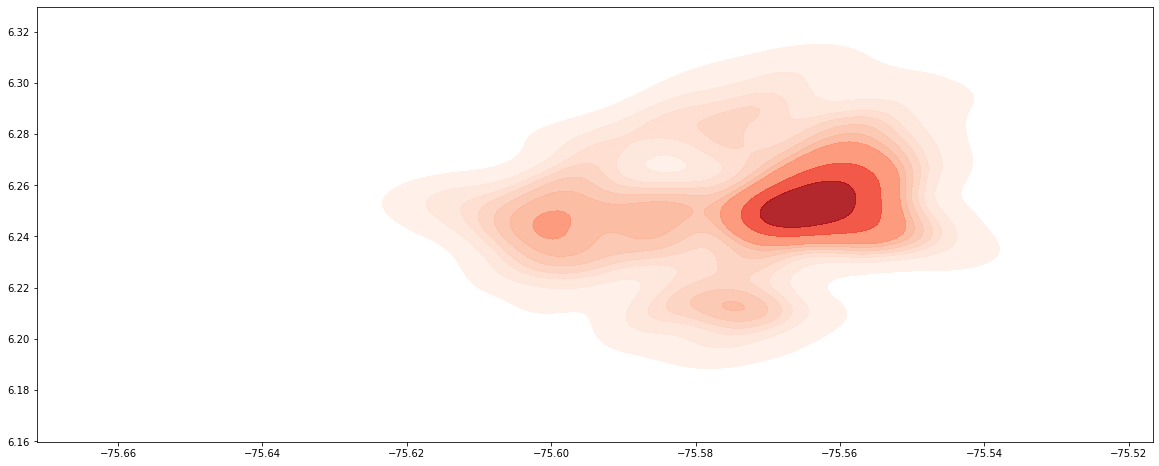

In [8]:
# Create thresholds
# Create plot
f, ax = plt.subplots(ncols=1, figsize=(20, 8))
# Kernel Density Estimation
kde = sns.kdeplot(
    ax=ax,
    x = hurtos_gdf['geometry'].x,
    y = hurtos_gdf['geometry'].y,
    # levels = levels,
    shade=True,
    cmap='Reds',
    alpha=0.9
)

# We load our Shape for Medellin city

In [7]:
comunas = gpd.read_file('/content/Limite_Barrio_Vereda_Catastral.shp')

#Se eliminan los datos faltantes de la columna identificadores de comunas
comunas = comunas.dropna(subset = ['CODIGO'])

#Se transforma el tipo de dato para poder cruzar este GeoDataFrame
comunas =  comunas.astype({'CODIGO':int})
comunas.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

# KDE plot over Medellín city shape

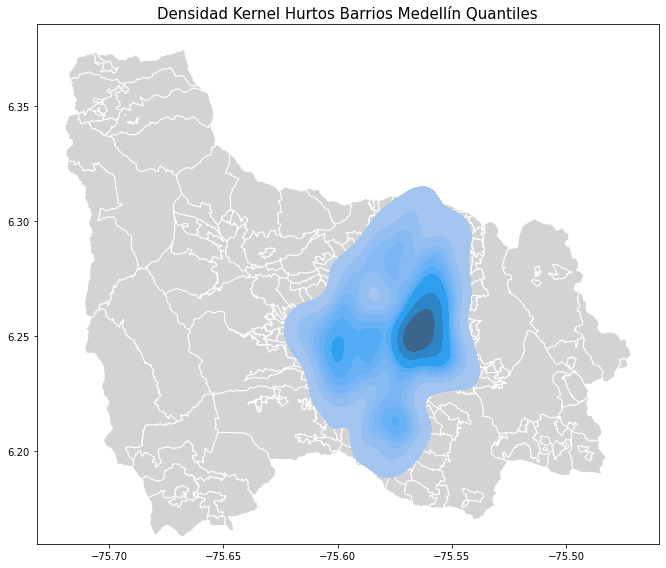

In [10]:
# Create thresholds
levels = [0.2,0.4,0.6,0.8,1]

# Create plot
f, ax = plt.subplots(ncols=1, figsize=(20, 8))

comunas.plot(ax = ax, color = 'lightgrey', edgecolor = 'white' )
# Kernel Density Estimation
kde = sns.kdeplot(
    ax=ax,
    x = hurtos_gdf['geometry'].x,
    y = hurtos_gdf['geometry'].y,
    # levels = levels,
    shade=True,

    # cmap='Reds',
    # alpha=0.9,
    legend = True
    
)

plt.title('Densidad Kernel Hurtos Barrios Medellín Quantiles', fontsize = 15)
plt.tight_layout()

# We classify between motorbikes robbery from apartments robbery

In [11]:
hurtos_gdf_residencia = hurtos_gdf[hurtos_gdf['Conducta'] == 'HURTO A RESIDENCIA' ]
hurto_gdf_moto = hurtos_gdf[hurtos_gdf['Conducta'] == 'HURTO DE MOTO' ]

No handles with labels found to put in legend.
No handles with labels found to put in legend.


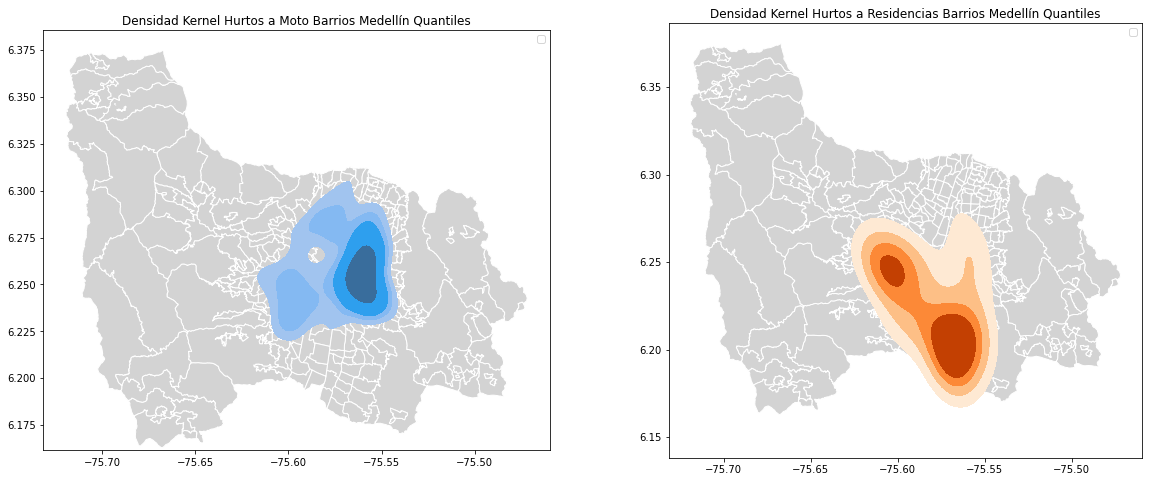

In [12]:
f, axs = plt.subplots(1,2, figsize=(20, 8))

comunas.plot(ax = axs[0], color = 'lightgrey', edgecolor = 'white' )
# Kernel Density Estimation
kde1 = sns.kdeplot(
    x = hurto_gdf_moto['geometry'].x,
    y = hurto_gdf_moto['geometry'].y,
    levels = levels,
    shade=True,
    # cmap='Reds',
    # alpha=0.9,
    legend = True,
    ax = axs[0]
)

kde1.set_title('Densidad Kernel Hurtos a Moto Barrios Medellín Quantiles')
kde1.legend()

comunas.plot(ax = axs[1], color = 'lightgrey', edgecolor = 'white' )
# Kernel Density Estimation
kde2 = sns.kdeplot(
    x = hurtos_gdf_residencia['geometry'].x,
    y = hurtos_gdf_residencia['geometry'].y,
    levels = levels,
    shade=True,
    cmap='Oranges',
    # alpha=0.9,
    legend = True,
    ax = axs[1],
)

kde2.set_title('Densidad Kernel Hurtos a Residencias Barrios Medellín Quantiles')
kde2.legend()


## Conclusion

We note with this Kernel Density Distribution that motorbikes robbery is spread mainly in the center, north, and west of the urban areas. On the other hand, apartment robbery is spread in the south, southwes.

# Apartment price Data

We load data from used price department and new price department.

In [8]:
import fiona

gpd.io.file.fiona.drvsupport.supported_drivers['KML'] = 'rw'
apt_usados = gpd.read_file('/content/APARTAMENTOS USADOS.xlsx.kml', driver='KML')
apt_nuevos = gpd.read_file('/content/APARTAMENTOS NUEVOS.xlsx.kml', driver='KML')

In [9]:
Data1 = pd.DataFrame()
for i in apt_nuevos['Description']:
  arr = np.array([item.split(':') for item in i.split('<br>')])
  arrD = dict(arr)
  Data1 = Data1.append(arrD, ignore_index = True)
apt_nuevos = apt_nuevos.merge(Data1, left_index = True, right_index = True)

apt_nuevos['Valor_m2'] = [i[1] for i in apt_nuevos['VALORM2'].str.split()]
apt_nuevos['Valor_m2'] = [i.replace(',', '') for i in apt_nuevos['Valor_m2']]
apt_nuevos['Valor_m2'] = [int(i) for i in apt_nuevos['Valor_m2']]


In [10]:
Data2 = pd.DataFrame()
for i in apt_usados['Description']:
  arr = np.array([item.split(':') for item in i.split('<br>')])
  arrD = dict(arr)
  Data2 = Data2.append(arrD, ignore_index = True)
apt_usados = apt_usados.merge(Data2, left_index = True, right_index = True)


apt_usados['Valor_m2'] = [i[1] for i in apt_usados['VALORM2'].str.split()]
apt_usados['Valor_m2'] = [i.replace(',', '') for i in apt_usados['Valor_m2']]
apt_usados['Valor_m2'] = [int(i) for i in apt_usados['Valor_m2']]

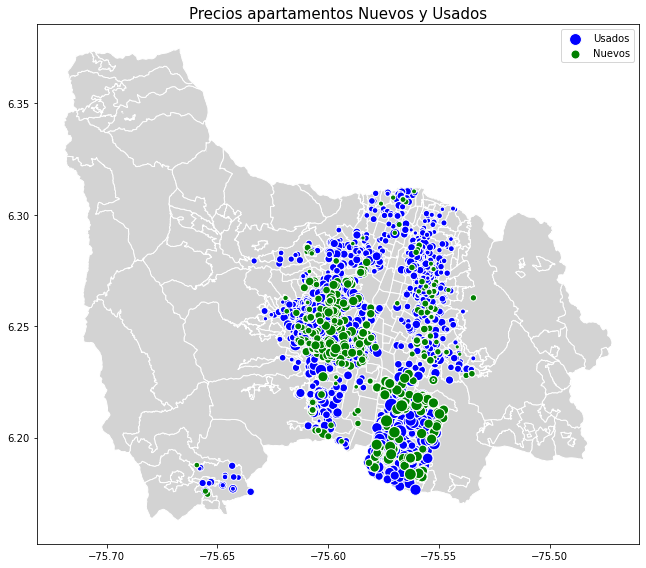

In [11]:
apt_usados['burbujas'] = 50*(apt_usados['Valor_m2']/apt_usados['Valor_m2'].quantile(q=0.25))
apt_nuevos['burbujas'] = 50*(apt_nuevos['Valor_m2']/apt_nuevos['Valor_m2'].quantile(q=0.25))

fig, ax = plt.subplots(ncols=1, figsize=(20, 8))

comunas.plot(ax = ax, color = 'lightgrey', edgecolor = 'white' )

s = apt_usados.plot(markersize = 'burbujas', edgecolor = 'white', c = 'b', legend = True, ax = ax)
# s.legend('Usados')

m = apt_nuevos.plot(markersize = 'burbujas', edgecolor = 'white', c = 'g', legend = True, ax = ax)
# m.legend('Nuevos')
plt.title('Precios apartamentos Nuevos y Usados', fontsize = 15)


ax.legend(['Usados', 'Nuevos'])



# handles, _ = s.legend(prop = 'sizes', alpha = 0.8)
# legend2 = ax.legend(handles, ["$q_1$", "$q_2$", "$q_3$", "$q_4$"])


plt.tight_layout()

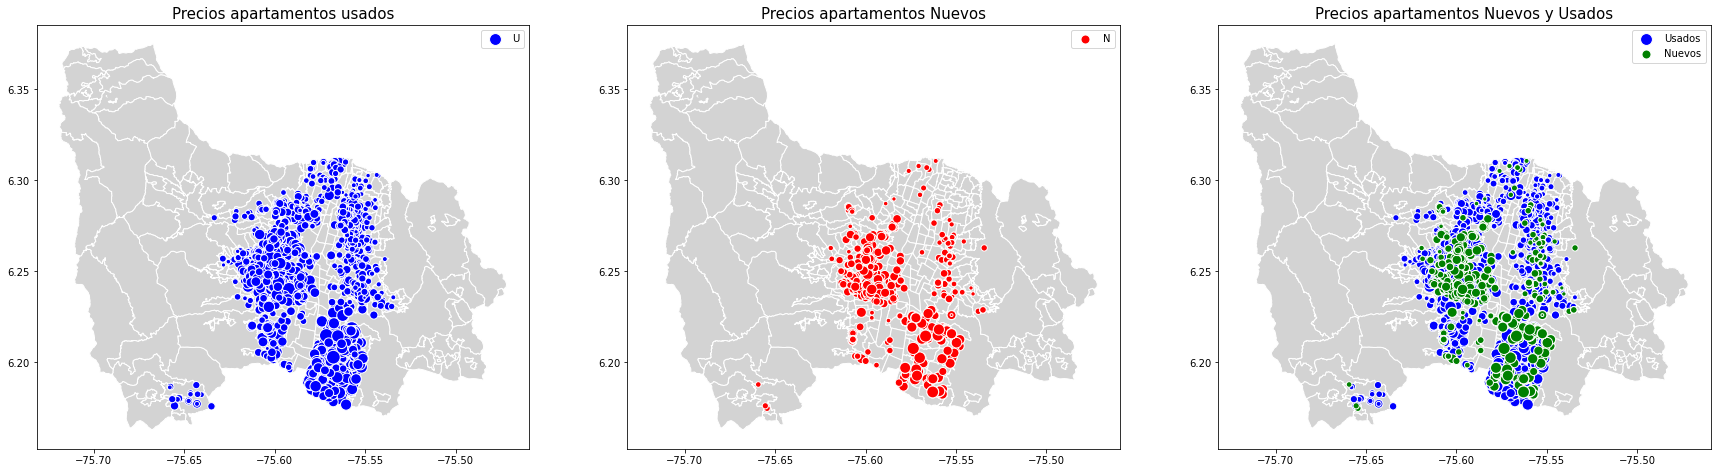

In [12]:
apt_usados['burbujas'] = 50*(apt_usados['Valor_m2']/apt_usados['Valor_m2'].quantile(q=0.25))
apt_nuevos['burbujas'] = 50*(apt_nuevos['Valor_m2']/apt_nuevos['Valor_m2'].quantile(q=0.25))

fig, ax = plt.subplots(1,3, figsize=(30, 8))

comunas.plot(ax = ax[0], color = 'lightgrey', edgecolor = 'white' )

s = apt_usados.plot(markersize = 'burbujas', edgecolor = 'white', c = 'b', legend = True, ax = ax[0])
s.legend('Usados')
ax[0].set_title('Precios apartamentos usados', fontsize = 15)




apt_usados['burbujas'] = 50*(apt_usados['Valor_m2']/apt_usados['Valor_m2'].quantile(q=0.25))
apt_nuevos['burbujas'] = 50*(apt_nuevos['Valor_m2']/apt_nuevos['Valor_m2'].quantile(q=0.25))



comunas.plot(ax = ax[1], color = 'lightgrey', edgecolor = 'white' )


f = apt_nuevos.plot(markersize = 'burbujas', edgecolor = 'white', c = 'r', legend = True, ax = ax[1])
f.legend('Nuevos')
ax[1].set_title('Precios apartamentos Nuevos', fontsize = 15)


apt_usados['burbujas'] = 50*(apt_usados['Valor_m2']/apt_usados['Valor_m2'].quantile(q=0.25))
apt_nuevos['burbujas'] = 50*(apt_nuevos['Valor_m2']/apt_nuevos['Valor_m2'].quantile(q=0.25))


comunas.plot(ax = ax[2], color = 'lightgrey', edgecolor = 'white' )

s = apt_usados.plot(markersize = 'burbujas', edgecolor = 'white', c = 'b', legend = True, ax = ax[2])
# s.legend('Usados')

m = apt_nuevos.plot(markersize = 'burbujas', edgecolor = 'white', c = 'g', legend = True, ax = ax[2])
# m.legend('Nuevos')
ax[2].set_title('Precios apartamentos Nuevos y Usados', fontsize = 15)


ax[2].legend(['Usados', 'Nuevos'])

# Conclusion

We observe similar behavior in our data, prices are higher mainly in the southwest and center west of the urban area both for used and new apartments. 

# Interpolation

Following https://pygis.io/docs/e_interpolation.html

In [14]:
precio_apt = pd.concat([apt_nuevos, apt_usados])
def estado(precio_apt):
  if (precio_apt['ESTADO'] == ' NUEVO     '):
    return 'Nuevo'
  
  elif (precio_apt['ESTADO'] == ' USADO     '):
    return 'Usado'

precio_apt['Estado'] = precio_apt.apply(estado, axis = 1)

nuevos_col =  (precio_apt['ESTADO'] == ' NUEVO     ')*1
usados_col = (precio_apt['ESTADO'] == ' USADO     ')*2
color = nuevos_col + usados_col


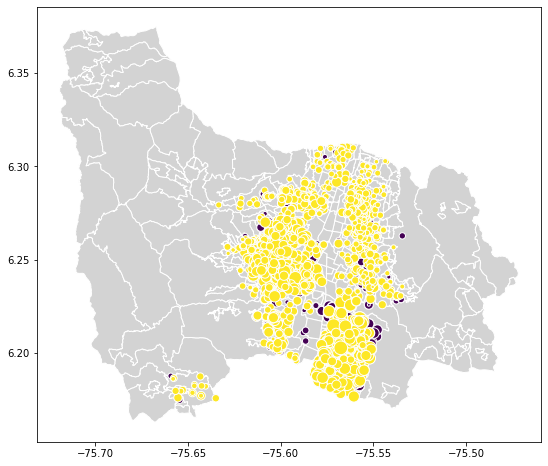

In [15]:
fig, ax = plt.subplots(ncols=1, figsize=(20, 8))

comunas.plot(ax = ax, color = 'lightgrey', edgecolor = 'white' )

s = precio_apt.plot(markersize = 'burbujas', edgecolor = 'white', c = color,  legend = True, ax = ax)

We work first with all prices together. 

In [41]:
# Get X and Y coordinates of prices of used apartmens 
x_precios = precio_apt['geometry'].x
y_precios = precio_apt['geometry'].y

# Create list of XY coordinates pairs 
coords_precios = [list(xy) for xy in zip(x_precios, y_precios)]

# Get extent of counties features
min_x_counties, min_y_counties, max_x_counties, max_y_counties = comunas.total_bounds

# Get  list of prices 'values'
value_precios = list(precio_apt['Valor_m2'])

#Create a copy of counties datasets
comunas_dissolved = comunas.copy()

#Add a field with constant value of 1 
comunas_dissolved['constant'] = 1

comunas_dissolved = comunas_dissolved.dissolve(by = 'constant').reset_index(drop = True)

In [28]:
def export_kde_raster(Z, XX, YY, min_x, max_x, min_y, max_y, proj, filename):
  '''Export and save a kernel density raster.'''
  #Get resolution
  xres = (max_x - min_x)/len(XX)
  yres = (max_y - min_y)/len(YY)

  #Set transform
  transform = Affine.translation(min_x - xres / 2, min_y - yres/2) * Affine.scale(xres, yres)

  # Export array as raster
  with rasterio.open(
      filename, 
      mode = 'w', 
      driver = 'GTiff',
      height = Z.shape[0],
      width = Z.shape[1],
      count = 1,
      dtype = Z.dtype,
      crs = proj, 
      transform = transform,

  ) as new_dataset:
          new_dataset.write(Z, 1)

# Assessing the model

In [42]:
#Split data into testing and training sets
coords_precios_train, coords_precios_test, value_precios_train, value_precios_test = train_test_split(coords_precios, value_precios, test_size = 0.20, random_state = 42)

# Create separate GeoDataFrames for testing and training sets
precios_train_gdf = gpd.GeoDataFrame(geometry = [Point(x,y) for x, y in coords_precios_train])     
precios_train_gdf = precios_train_gdf.set_crs('epsg:4326')
precios_train_gdf['Actual_Value'] = value_precios_train

precios_test_gdf = gpd.GeoDataFrame(geometry = [Point(x,y) for x, y in coords_precios_test])
precios_test_gdf = precios_test_gdf.set_crs('epsg:4326')
precios_test_gdf['Actual_Value'] = value_precios_test

min_x_precios, min_y_precios, max_x_precios, max_y_precios = precios_train_gdf.total_bounds

Text(0.5, 1.0, 'Precios apartamentos de Medellín')

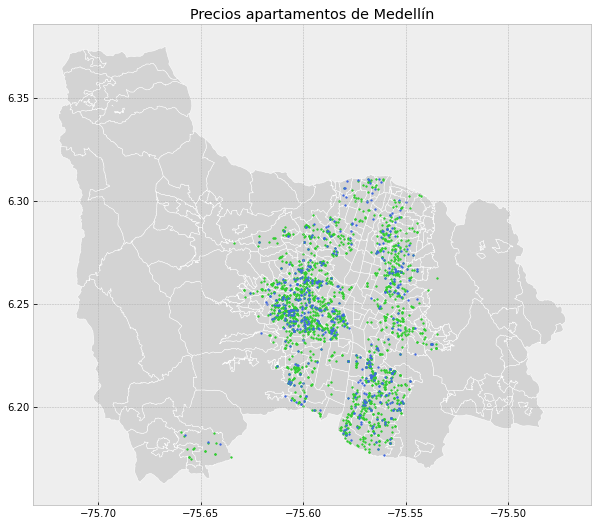

In [30]:
#Create subplots
fig, ax = plt.subplots(1,1, figsize = (10,10))

#Style plots
plt.style.use('bmh')

comunas.plot(ax = ax, 
             color = 'lightgrey', edgecolor = 'white')
precios_train_gdf.plot(ax = ax, marker = 'o', color = 'limegreen', markersize = 3)
precios_test_gdf.plot(ax = ax, marker = 'o', color = 'royalblue', markersize = 3)

ax.set_title('Precios apartamentos de Medellín')

# Kriging estimation

In [43]:
# Create a 100 by 100 grid
# Horizontal and vertical cell counts should be the same 

XX_pk_krig = np.linspace(min_x_precios, max_x_precios, 100)
YY_pk_krig = np.linspace(min_y_precios, max_y_precios, 100)

# Generate ordinay kriging object
OK = OrdinaryKriging(
    np.array(x_precios),
    np.array(y_precios),
    value_precios, 
    variogram_model = 'linear',
    verbose = False,
    enable_plotting = False,
    coordinates_type = 'euclidean',
)

# Evaluate the method on grid

Z_pk_krig, sigma_squared_p_krig = OK.execute('grid', XX_pk_krig, YY_pk_krig)

proj_wgs = 4326

# Export raster
export_kde_raster(Z = Z_pk_krig, XX = XX_pk_krig, YY = YY_pk_krig,
                  min_x = min_x_precios, max_x = max_x_precios, min_y = min_y_precios, max_y = max_y_precios,
                  proj = proj_wgs, filename = "/content/kriging_sin_filtrar.tif")

#Open raster
raster_pk = rasterio.open( "/content/kriging_sin_filtrar.tif")

# Create polygon with extent of raster
poly_shapely = box(*raster_pk.bounds)

# Create a dictionary with needed attributes and required geometry columns
attributes_df = {'Attribute': ['name1'], 'geometry': poly_shapely}

#Convert shapely object to a GeoDataframe
raster_pk_extent = gpd.GeoDataFrame(attributes_df, geometry = 'geometry', crs = proj_wgs)

#Create copy of test dataset
precios_test_gdf_pk_krig = precios_test_gdf.copy()

# Subset the GeoDataFrame by checking which test points are within the raster extent polygon
# If a test point is beyond the extent of training points dataset, the kriging output may not cover that test point
precios_test_gdf_pk_krig = precios_test_gdf_pk_krig[precios_test_gdf_pk_krig.within(raster_pk_extent.geometry.values[0])]


#Create list of XY coordinate pairs for the test point that fall within raster extent polygon
coords_precios_test_pk_krig = [list(xy) for xy in zip(precios_test_gdf_pk_krig['geometry'].x, precios_test_gdf_pk_krig['geometry'].y)]

#Extract raster value at each test point and add the values to the GeoDataframe
precios_test_gdf_pk_krig['VALUE_Predict'] = [x[0] for x in raster_pk.sample(coords_precios_test_pk_krig)]

In [44]:
#Generate out-of-sample R^2
out_r_squared_tp = r2_score(precios_test_gdf_pk_krig.Actual_Value, precios_test_gdf_pk_krig.VALUE_Predict)
print('Pykrige Kriging out-of-sample r-squared: {}'.format(round(out_r_squared_tp,2)))

Pykrige Kriging out-of-sample r-squared: 0.59


In [45]:
#Display attribute table
print('\nAttribute Table: Random Points Interpolated Values - PyKrige Kriging Method')
display(precios_test_gdf_pk_krig.head(2))


Attribute Table: Random Points Interpolated Values - PyKrige Kriging Method


,geometry,Actual_Value,VALUE_Predict
0,POINT (-75.55930 6.20557),4410256,4.604543e+06
1,POINT (-75.58881 6.26004),2736842,4.088399e+06


#Variograma datos completos

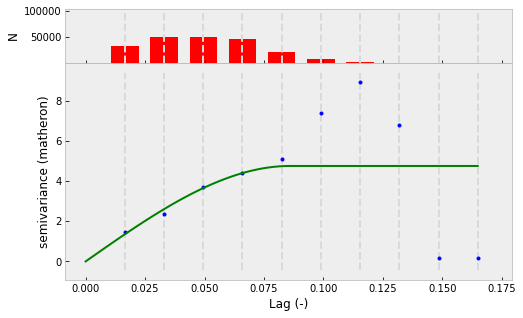

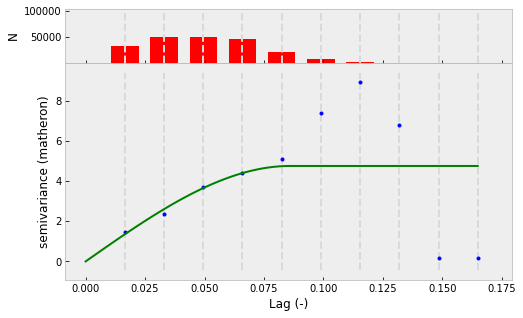

In [55]:
import skgstat as skg

# spherical
V = skg.Variogram(coords_precios, value_precios,)
V.plot()

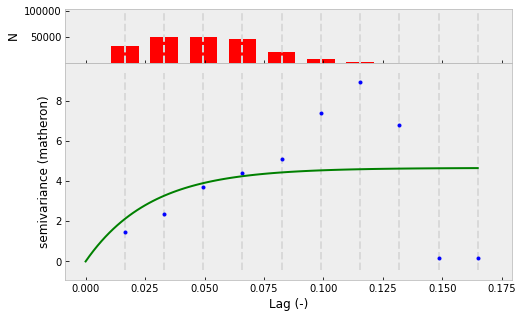

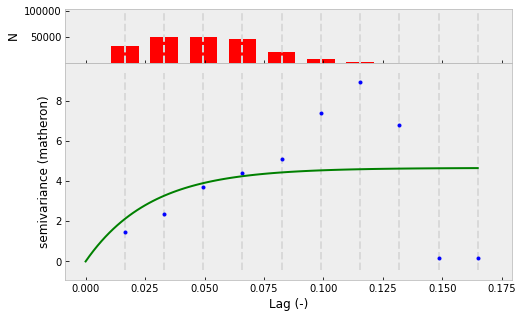

In [58]:
# exponential
V = skg.Variogram(coords_precios, value_precios, model = 'exponential')
V.plot()

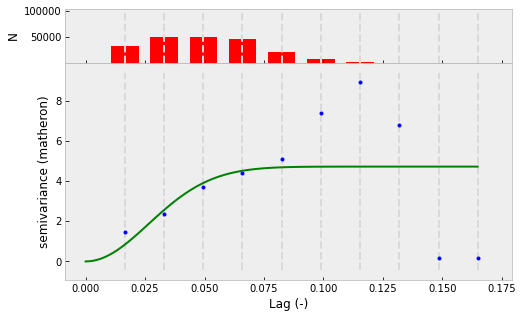

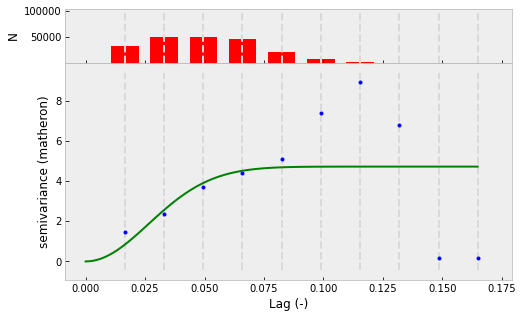

In [59]:
# gaussian
V = skg.Variogram(coords_precios, value_precios, model = 'gaussian')
V.plot()

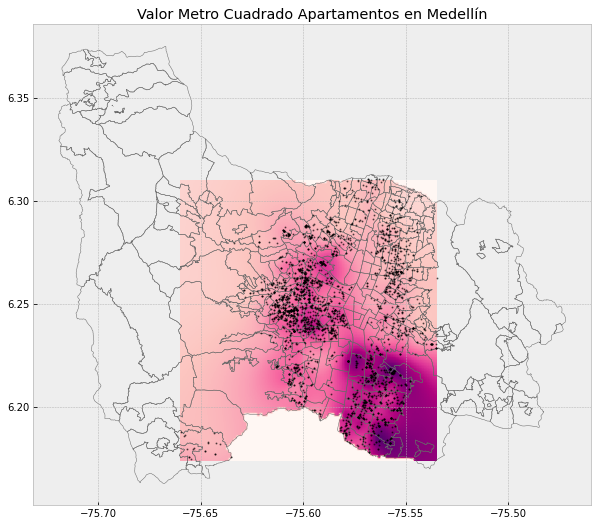

In [34]:
#Mask raster to counties shape
out_image_pk, out_transform_pk = rasterio.mask.mask(raster_pk, comunas.geometry.values, crop = True)

#Stylize plots
plt.style.use('bmh')

# Plot data
fig, ax = plt.subplots(1, figsize = (10,10))
show(out_image_pk, ax = ax, transform = out_transform_pk, cmap = 'RdPu')
ax.plot(x_precios, y_precios, 'k.', markersize = 2, alpha = 0.5)
comunas.plot(ax=ax, color = 'none', edgecolor = 'dimgray')
plt.gca().invert_yaxis()

#Set title
ax.set_title('Valor Metro Cuadrado Apartamentos en Medellín')

#Display plot
plt.show()

# Used apartments

In [47]:
# Get X and Y coordinates of prices of used apartmens 
x_precios = apt_usados['geometry'].x
y_precios = apt_usados['geometry'].y

# Create list of XY coordinates pairs 
coords_precios = [list(xy) for xy in zip(x_precios, y_precios)]

# Get extent of counties features
min_x_counties, min_y_counties, max_x_counties, max_y_counties = comunas.total_bounds

# Get  list of prices 'values'
value_precios = list(apt_usados['Valor_m2'])

#Create a copy of counties datasets
comunas_dissolved = comunas.copy()

#Add a field with constant value of 1 
comunas_dissolved['constant'] = 1

comunas_dissolved = comunas_dissolved.dissolve(by = 'constant').reset_index(drop = True)


#Split data into testing and training sets
coords_precios_train, coords_precios_test, value_precios_train, value_precios_test = train_test_split(coords_precios, value_precios, test_size = 0.20, random_state = 42)

# Create separate GeoDataFrames for testing and training sets
precios_train_gdf = gpd.GeoDataFrame(geometry = [Point(x,y) for x, y in coords_precios_train])     
precios_train_gdf = precios_train_gdf.set_crs('epsg:4326')
precios_train_gdf['Actual_Value'] = value_precios_train

precios_test_gdf = gpd.GeoDataFrame(geometry = [Point(x,y) for x, y in coords_precios_test])
precios_test_gdf = precios_test_gdf.set_crs('epsg:4326')
precios_test_gdf['Actual_Value'] = value_precios_test

min_x_precios, min_y_precios, max_x_precios, max_y_precios = precios_train_gdf.total_bounds


# Create a 100 by 100 grid
# Horizontal and vertical cell counts should be the same 

XX_pk_krig = np.linspace(min_x_precios, max_x_precios, 100)
YY_pk_krig = np.linspace(min_y_precios, max_y_precios, 100)

# Generate ordinay kriging object
OK = OrdinaryKriging(
    np.array(x_precios),
    np.array(y_precios),
    value_precios, 
    variogram_model = 'linear',
    verbose = False,
    enable_plotting = False,
    coordinates_type = 'euclidean',
)

# Evaluate the method on grid

Z_pk_krig, sigma_squared_p_krig = OK.execute('grid', XX_pk_krig, YY_pk_krig)

proj_wgs = 4326

# Export raster
export_kde_raster(Z = Z_pk_krig, XX = XX_pk_krig, YY = YY_pk_krig,
                  min_x = min_x_precios, max_x = max_x_precios, min_y = min_y_precios, max_y = max_y_precios,
                  proj = proj_wgs, filename = "/content/kriging_usados.tif")

#Open raster
raster_pk = rasterio.open( "/content/kriging_usados.tif")

# Create polygon with extent of raster
poly_shapely = box(*raster_pk.bounds)

# Create a dictionary with needed attributes and required geometry columns
attributes_df = {'Attribute': ['name1'], 'geometry': poly_shapely}

#Convert shapely object to a GeoDataframe
raster_pk_extent = gpd.GeoDataFrame(attributes_df, geometry = 'geometry', crs = proj_wgs)

#Create copy of test dataset
precios_test_gdf_pk_krig = precios_test_gdf.copy()

# Subset the GeoDataFrame by checking which test points are within the raster extent polygon
# If a test point is beyond the extent of training points dataset, the kriging output may not cover that test point
precios_test_gdf_pk_krig = precios_test_gdf_pk_krig[precios_test_gdf_pk_krig.within(raster_pk_extent.geometry.values[0])]


#Create list of XY coordinate pairs for the test point that fall within raster extent polygon
coords_precios_test_pk_krig = [list(xy) for xy in zip(precios_test_gdf_pk_krig['geometry'].x, precios_test_gdf_pk_krig['geometry'].y)]

#Extract raster value at each test point and add the values to the GeoDataframe
precios_test_gdf_pk_krig['VALUE_Predict'] = [x[0] for x in raster_pk.sample(coords_precios_test_pk_krig)]


#Generate out-of-sample R^2
out_r_squared_tp = r2_score(precios_test_gdf_pk_krig.Actual_Value, precios_test_gdf_pk_krig.VALUE_Predict)
print('Pykrige Kriging out-of-sample r-squared: {}'.format(round(out_r_squared_tp,2)))


#Display attribute table
print('\nAttribute Table: Random Points Interpolated Values - PyKrige Kriging Method')
display(precios_test_gdf_pk_krig.head(2))

Pykrige Kriging out-of-sample r-squared: 0.47

Attribute Table: Random Points Interpolated Values - PyKrige Kriging Method


,geometry,Actual_Value,VALUE_Predict
0,POINT (-75.59711 6.25278),4500000,3.780792e+06
1,POINT (-75.60060 6.26300),3495146,3.435550e+06


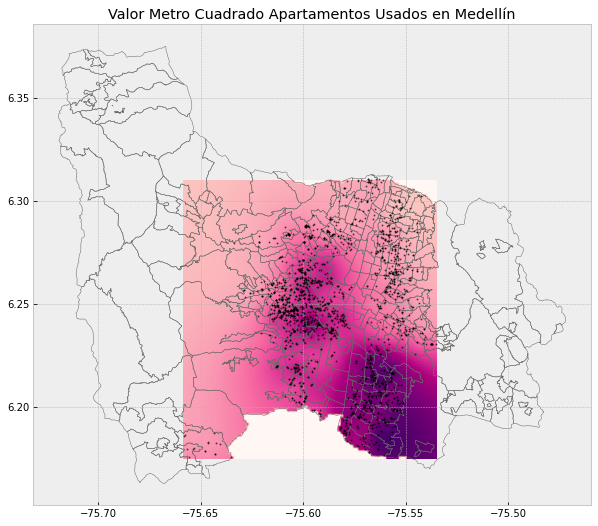

In [48]:
#Mask raster to counties shape
out_image_pk, out_transform_pk = rasterio.mask.mask(raster_pk, comunas.geometry.values, crop = True)

#Stylize plots
plt.style.use('bmh')

# Plot data
fig, ax = plt.subplots(1, figsize = (10,10))
show(out_image_pk, ax = ax, transform = out_transform_pk, cmap = 'RdPu')
ax.plot(x_precios, y_precios, 'k.', markersize = 2, alpha = 0.5)
comunas.plot(ax=ax, color = 'none', edgecolor = 'dimgray')
plt.gca().invert_yaxis()

#Set title
ax.set_title('Valor Metro Cuadrado Apartamentos Usados en Medellín')

#Display plot
plt.show()

# New apartments

In [49]:
# Get X and Y coordinates of prices of used apartmens 
x_precios = apt_nuevos['geometry'].x
y_precios = apt_nuevos['geometry'].y

# Create list of XY coordinates pairs 
coords_precios = [list(xy) for xy in zip(x_precios, y_precios)]

# Get extent of counties features
min_x_counties, min_y_counties, max_x_counties, max_y_counties = comunas.total_bounds

# Get  list of prices 'values'
value_precios = list(apt_nuevos['Valor_m2'])

#Create a copy of counties datasets
comunas_dissolved = comunas.copy()

#Add a field with constant value of 1 
comunas_dissolved['constant'] = 1

comunas_dissolved = comunas_dissolved.dissolve(by = 'constant').reset_index(drop = True)


#Split data into testing and training sets
coords_precios_train, coords_precios_test, value_precios_train, value_precios_test = train_test_split(coords_precios, value_precios, test_size = 0.20, random_state = 42)

# Create separate GeoDataFrames for testing and training sets
precios_train_gdf = gpd.GeoDataFrame(geometry = [Point(x,y) for x, y in coords_precios_train])     
precios_train_gdf = precios_train_gdf.set_crs('epsg:4326')
precios_train_gdf['Actual_Value'] = value_precios_train

precios_test_gdf = gpd.GeoDataFrame(geometry = [Point(x,y) for x, y in coords_precios_test])
precios_test_gdf = precios_test_gdf.set_crs('epsg:4326')
precios_test_gdf['Actual_Value'] = value_precios_test

min_x_precios, min_y_precios, max_x_precios, max_y_precios = precios_train_gdf.total_bounds


# Create a 100 by 100 grid
# Horizontal and vertical cell counts should be the same 

XX_pk_krig = np.linspace(min_x_precios, max_x_precios, 100)
YY_pk_krig = np.linspace(min_y_precios, max_y_precios, 100)

# Generate ordinay kriging object
OK = OrdinaryKriging(
    np.array(x_precios),
    np.array(y_precios),
    value_precios, 
    variogram_model = 'linear',
    verbose = False,
    enable_plotting = False,
    coordinates_type = 'euclidean',
)

# Evaluate the method on grid

Z_pk_krig, sigma_squared_p_krig = OK.execute('grid', XX_pk_krig, YY_pk_krig)

proj_wgs = 4326

# Export raster
export_kde_raster(Z = Z_pk_krig, XX = XX_pk_krig, YY = YY_pk_krig,
                  min_x = min_x_precios, max_x = max_x_precios, min_y = min_y_precios, max_y = max_y_precios,
                  proj = proj_wgs, filename = "/content/kriging_nuevos.tif")

#Open raster
raster_pk = rasterio.open( "/content/kriging_nuevos.tif")

# Create polygon with extent of raster
poly_shapely = box(*raster_pk.bounds)

# Create a dictionary with needed attributes and required geometry columns
attributes_df = {'Attribute': ['name1'], 'geometry': poly_shapely}

#Convert shapely object to a GeoDataframe
raster_pk_extent = gpd.GeoDataFrame(attributes_df, geometry = 'geometry', crs = proj_wgs)

#Create copy of test dataset
precios_test_gdf_pk_krig = precios_test_gdf.copy()

# Subset the GeoDataFrame by checking which test points are within the raster extent polygon
# If a test point is beyond the extent of training points dataset, the kriging output may not cover that test point
precios_test_gdf_pk_krig = precios_test_gdf_pk_krig[precios_test_gdf_pk_krig.within(raster_pk_extent.geometry.values[0])]


#Create list of XY coordinate pairs for the test point that fall within raster extent polygon
coords_precios_test_pk_krig = [list(xy) for xy in zip(precios_test_gdf_pk_krig['geometry'].x, precios_test_gdf_pk_krig['geometry'].y)]

#Extract raster value at each test point and add the values to the GeoDataframe
precios_test_gdf_pk_krig['VALUE_Predict'] = [x[0] for x in raster_pk.sample(coords_precios_test_pk_krig)]


#Generate out-of-sample R^2
out_r_squared_tp = r2_score(precios_test_gdf_pk_krig.Actual_Value, precios_test_gdf_pk_krig.VALUE_Predict)
print('Pykrige Kriging out-of-sample r-squared: {}'.format(round(out_r_squared_tp,2)))


#Display attribute table
print('\nAttribute Table: Random Points Interpolated Values - PyKrige Kriging Method')
display(precios_test_gdf_pk_krig.head(2))

Pykrige Kriging out-of-sample r-squared: 0.75

Attribute Table: Random Points Interpolated Values - PyKrige Kriging Method


,geometry,Actual_Value,VALUE_Predict
0,POINT (-75.55248 6.22578),615530,4.514805e+06
1,POINT (-75.60251 6.23941),5130435,5.088187e+06


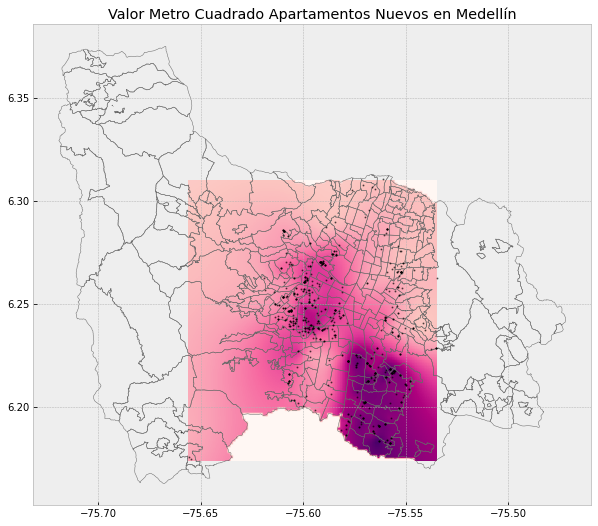

In [50]:
#Mask raster to counties shape
out_image_pk, out_transform_pk = rasterio.mask.mask(raster_pk, comunas.geometry.values, crop = True)

#Stylize plots
plt.style.use('bmh')

# Plot data
fig, ax = plt.subplots(1, figsize = (10,10))
show(out_image_pk, ax = ax, transform = out_transform_pk, cmap = 'RdPu')
ax.plot(x_precios, y_precios, 'k.', markersize = 2, alpha = 0.5)
comunas.plot(ax=ax, color = 'none', edgecolor = 'dimgray')
plt.gca().invert_yaxis()

#Set title
ax.set_title('Valor Metro Cuadrado Apartamentos Nuevos en Medellín')

#Display plot
plt.show()

# Conclusion

With this linear interpolation method we confirm the conclusion got on the exploratory results. Apartment prices are higher in the southwest and center west of the urban area of Medellín city. 